# In this notebook, I look at each dataset independently and then compare them with one another. The ultimate goal is to have 1 master dataset that I can then manipulate

I need to clean each data set independently. This is going to avoid data leakage but it will mean constructing a slightly more elaborate data pipeline down the road. 

The seoncd model, the webis 2016 data base is the least usuable overall. The tweets do contain urls that I could then go into an scrape for headlines. I may do that If my model doesn't have enough data with the 2 data sets that I have.

In [1]:
# Utility functions
import pandas as pd
import numpy as np
from warnings import filterwarnings
import string
from tqdm import tqdm

tqdm.pandas(desc="progress-bar")

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# NLP
import nltk
from textblob import TextBlob
import re


# Feature extration 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
import gensim

# Statistics
from scipy import stats

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Set a random seed
np.random.seed(42)

# magic line
%matplotlib inline
# Set theme
plt.style.use('ggplot')
#ignore warnings
filterwarnings('ignore')

# ================= Uncomment if stopwords throws and error ======================== # 

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
#nltk.download('words')

In [207]:
# Define Stop words
stop_words = set(stopwords.words("english"))
# Extend stopwords (see analysis below)
extension = {
    'trumps',
    'trump',
    'obama',
    'donald',
    'news',
    'news'
    'u'
}

publications = {
    'abc',
    'bbc',
    'bleacher',
    'buzzfeed',
    'cnn',
    'espn',
    'forbes',
    'fox',
    'huffington',
    'mashable',
    'nbc',
    'guardian',
    'independent',
    'telegraph',
    'washingtonpost',
    'yahoo'
}
stop_words.update(extension)
stop_words.update(publications)

print('trump' in stop_words)

True


### This note book will contain the visualizations necessary to motivate intuition on the corpus
- tokinasation 
- stopword creation and removal
- Lexicon normalization


## Thoughts and conclusions:

I have demonstrated that the second dataset, as a whole should not be included. The

In [208]:
def get_false_positives(predictions, y_test):
    """
    Returns a numpy array of index matched false negatives
    predictions --> binary or bool
    y_test --> binary or bool
    theshold 
    
    returns a np.array
    """
    comparisons = list(zip(y_test, predictions))
    return np.array([1 if (true == 0 and prediction == 1) else 0 for true, prediction in comparisons])

def get_false_negatives(predictions, y_test):
    """
    Returns a numpy array of index matched false negatives
    predictions --> binary or bool
    y_test --> binary or bool
    theshold 
    
    returns a np.array
    """
    comparisons = list(zip(y_test, predictions))
    return np.array([1 if (true == 1 and prediction == 0) else 0 for true, prediction in comparisons])

In [209]:
# Load dataframe 1
PATH = '../../src/data/dataframe1.csv'

df = pd.read_csv(PATH)
df.head()

,text,target
0,Bill Changing Credit Card Rules Is Sent to Oba...,0
1,"In Hollywood, the Easy-Money Generation Toughe...",0
2,1700 runners still unaccounted for in UK's Lak...,0
3,Yankees Pitchers Trade Fielding Drills for Put...,0
4,Large earthquake rattles Indonesia; Seventh in...,0


In [210]:
df.shape

(32000, 2)

### Split the data into training and test sets

In [211]:
X = df.drop(columns=['target'])
y = df[['target']]
X.shape, y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25600, 1), (6400, 1), (25600, 1), (6400, 1))

Text(0, 0.5, 'Document Count')

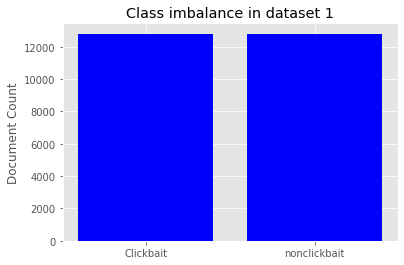

In [212]:
# Visualize the classes
plt.bar(x=['Clickbait', 'nonclickbait'], height=y_train.groupby(['target']).target.count(), color='b');
plt.title("Class imbalance in dataset 1")
plt.ylabel("Document Count")

### Visualize the class difference

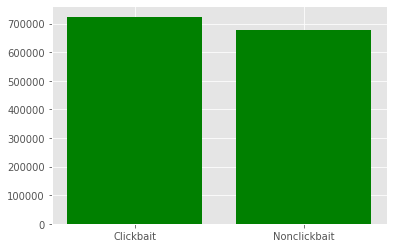

In [213]:
# Create a corpus of clickbait and nonclickbait

# join all of the messages from each class into their respective corpus
df = pd.concat([X_train, y_train], axis=1)
click = df[df.target == 1]
non = df[df.target == 0]

# Create large strings of each
click_corpus = " ".join(click.text.to_list())
non_corpus = " ".join(non.text.to_list())

plt.bar(x=['Clickbait', 'Nonclickbait'], height=[len(click_corpus), len(non_corpus)], color = 'g');

click bait corpus just seems a little bit longer than the non-clickbait corpus. Let's see of the overlapping histograms of each titles length reveals anything

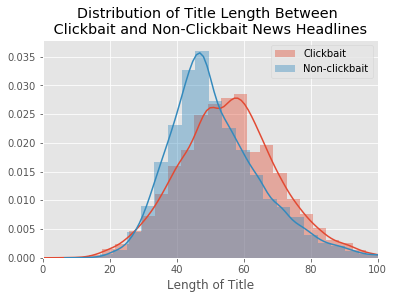

In [214]:
def get_len(string):
    return len(string)

click_len = click.text.apply(get_len)
non_len = non.text.apply(get_len)

fig, ax = plt.subplots()
for a, b in zip([click_len, non_len], ['Clickbait', 'Non-clickbait']):
    sns.distplot(a, bins=30, ax=ax, kde=True, label=b)
    plt.legend()
ax.set_xlim([0, 100])
ax.set_xlabel("Length of Title")
ax.set_title("Distribution of Title Length Between \n Clickbait and Non-Clickbait News Headlines ");

It seems that clickbait titles are slightly longer on average. I will conduct a students ttest between the two groups to see if there is significance 

In [215]:
# test for normality:
stats.normaltest(non_len), stats.normaltest(click_len)

(NormaltestResult(statistic=1866.1603570633722, pvalue=0.0),
 NormaltestResult(statistic=85.52377864217378, pvalue=2.683783213192833e-19))

Despite looking very normal, the distributions are not normal. 

In [216]:
significance = stats.mannwhitneyu(click_len, non_len)
mean_dif = int(round((click_len.mean()-non_len.mean()), 0))
print(f"Clickbait titles are on Average {mean_dif} words longer than non clickbait titles with a p value of {significance[1]}")

Clickbait titles are on Average 4 words longer than non clickbait titles with a p value of 2.0717424030770497e-138


Next, let's look at the bag of words represented by each class. To do that, first, I will tokenise each of the bag of words and then create a frequency dictionary of each class and plot the results.

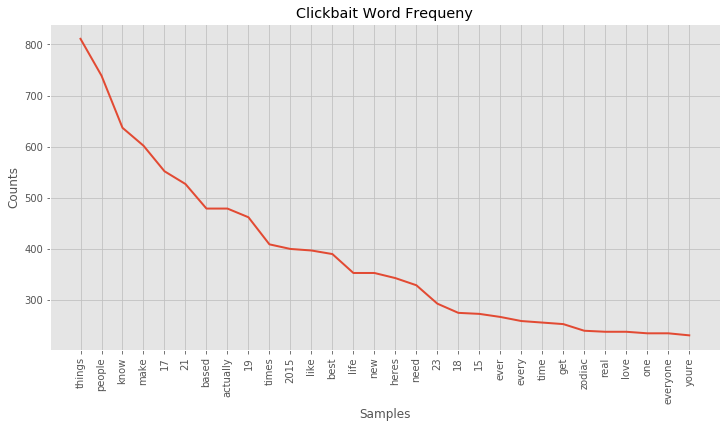

In [217]:
# Tokenizer 
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
click_tokenized = tokenizer.tokenize(click_corpus)
non_tokenized = tokenizer.tokenize(non_corpus)

fil_click = [word.lower() for word in click_tokenized if word.lower() not in stop_words]
fil_non = [word.lower() for word in non_tokenized if word.lower() not in stop_words]

# Freq Dict
click_dict = FreqDist(fil_click)
non_dict = FreqDist(fil_non)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

click_dict.plot(30, title="Clickbait Word Frequeny")

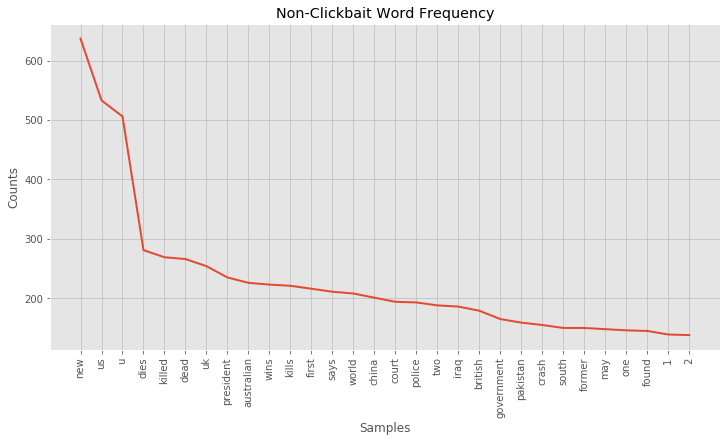

In [218]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

non_dict.plot(30, title="Non-Clickbait Word Frequency");

The composition of the words are very different. I really think a naive bayes would work for this right out of the gate. However, i have more questions about the corpus.

As an aside, I should look into removing all proper nouns from the corpus in order to increase the generalizability of the model. Obama, Trump place names too. These are all things that are relevant at the time of making the model but in the coming years will be less and less important.

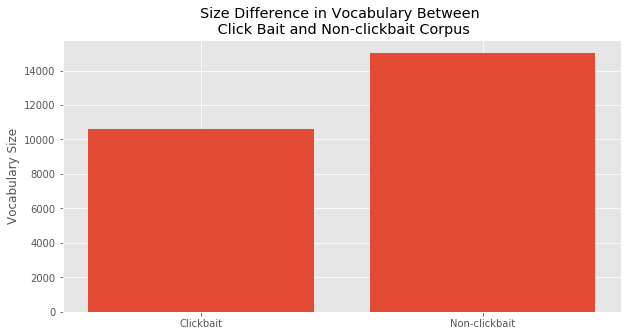

In [219]:
# Vocabulary check
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(x=["Clickbait", "Non-clickbait"], height=[len(click_dict), len(non_dict)])
ax.set_ylabel("Vocabulary Size")
plt.title("Size Difference in Vocabulary Between \n Click Bait and Non-clickbait Corpus");

## Considering the difference in Vocabulary Sizes, I am interested in Visualizing those differences using word clouds

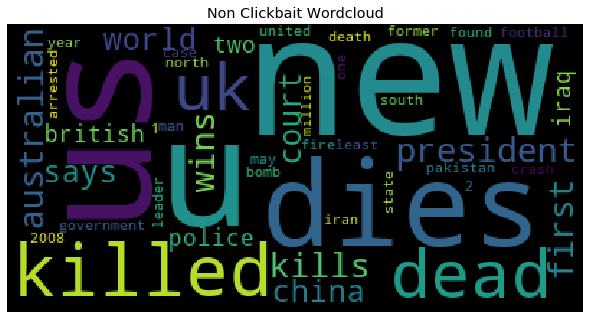

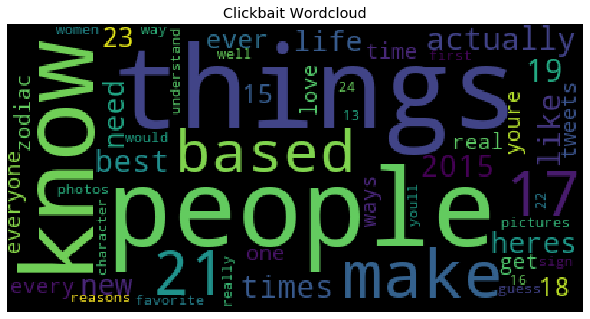

In [220]:
wordcloud  = WordCloud(min_font_size=10).generate_from_frequencies(non_dict)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Non Clickbait Wordcloud")
plt.tight_layout(pad = 0) 
  
plt.show() 

wordcloud  = WordCloud(min_font_size=10).generate_from_frequencies(click_dict)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Clickbait Wordcloud")
plt.tight_layout(pad = 0) 
  
plt.show() 

So it would seem that there are upwars of 4000 more unique words in the non-clickbait corpus. How many different words are there between the two corpus's?

In [221]:
# Using python sets
non_set = set(non_dict.keys())
click_set = set(click_dict.keys())

diff = non_set.difference(click_set)
overlap = non_set.intersection(click_set)

# Generate word clouds of each


def countX(lst, x): 
    return lst.count(x) 

def freq_of_specific_words(tokenized_list, list_of_interest):
    freqDict = {}
    for word in list_of_interest:
        freqDict[word] = countX(tokenized_list, word)
    
    
non_diff = {}
for word in diff:
    non_diff[word] = countX(non_tokenized, word)

difference_frequency = sorted(non_diff.items(), reverse=True, key = (lambda x: x[1]))

## Visualize the Differences Between The Classes

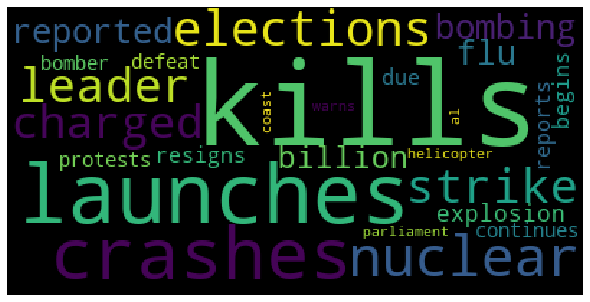

In [222]:
wordcloud  = WordCloud(min_font_size=10).generate_from_frequencies(dict(difference_frequency))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Visualize the Intersection Between the Classes

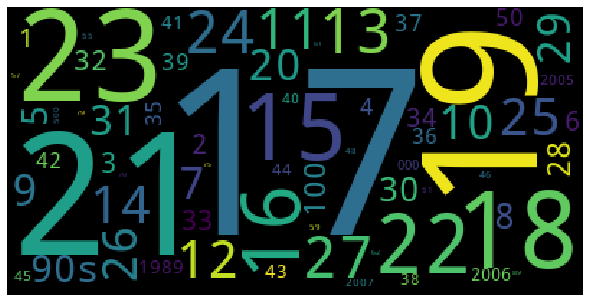

In [223]:
# Visualize the intersection between the two corpus

click_diff = {}
for word in overlap:
    click_diff[word] = countX(click_tokenized, word)

difference_frequency = sorted(click_diff.items(), reverse=True, key = (lambda x: x[1]))
wordcloud  = WordCloud(min_font_size=5).generate_from_frequencies(dict(difference_frequency))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Wow. Every overlapping string is actually a number. This begs the question, what proportion of each of the classes are numerical? If the overlapping words 

# Sentiment Analysis.

Specifically, I am interested in the difference in objectivity between the two classes. To do this I will use text blob.

Where a higher score means more opinionated. My hypothesis is that clickbait articles are on the whole less opinioted. They will likely use definite articles and hyperbole which I believe will register as being objective truth.

In [224]:
clickbait_example = click.text.iloc[3]
clickblob = TextBlob(clickbait_example)
print(clickblob.sentiment)


nonclickbait_example = non.text.iloc[7]
nonblob = TextBlob(nonclickbait_example)
print(nonblob.sentiment[1])

Sentiment(polarity=0.0, subjectivity=0.125)
0.0


In [225]:
def cleaner(tweet):
    text=re.compile("(http\w+)")
    tweet= tweet.replace("RT", "")
    tweet = "".join([char.lower() for char in tweet if char not in string.punctuation + "’" + "‘" + "“" + "–"])
    return " ".join(word for word in tweet.split() if word not in text.findall(tweet))

def get_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment[1]

def get_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment[0]

click_sentiment = click.text.apply(get_subjectivity)
non_sentiment = non.text.apply(get_subjectivity)

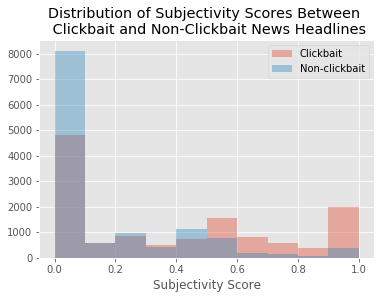

In [226]:
# Plot Subjectivity
fig, ax = plt.subplots()
for a, b in zip([click_sentiment, non_sentiment], ['Clickbait', 'Non-clickbait']):
    sns.distplot(a, bins=10, ax=ax, kde=False, label=b)
    plt.legend()
# ax.set_xlim([0, 100])
ax.set_xlabel("Subjectivity Score")
ax.set_title("Distribution of Subjectivity Scores Between \n Clickbait and Non-Clickbait News Headlines");

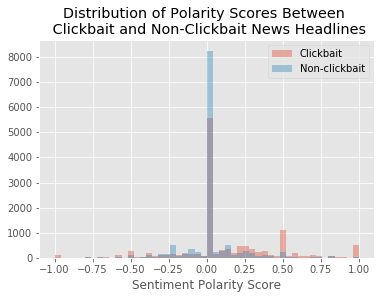

In [227]:
# Plot Sentiment polarity
click_subjectivity = click.text.apply(get_polarity)
non_subjectivity = non.text.apply(get_polarity)

fig, ax = plt.subplots()
for a, b in zip([click_subjectivity, non_subjectivity], ['Clickbait', 'Non-clickbait']):
    sns.distplot(a, bins=50, ax=ax, kde=False, label=b)
    plt.legend()
# ax.set_xlim([0, 100])
ax.set_xlabel("Sentiment Polarity Score")
ax.set_title("Distribution of Polarity Scores Between \n Clickbait and Non-Clickbait News Headlines");

Despite what I thought, the click bait titles were far more opinionated than the normal headlines. In addition, the sentiment polarity of 

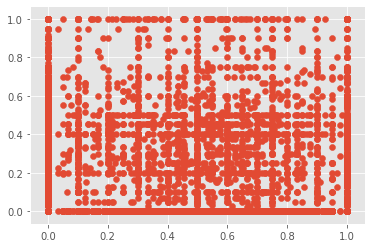

In [228]:
plt.scatter(click_sentiment, non_sentiment.iloc[0:len(click)]);

# I think we have seen enough to run a simple Naive Bayes Classifier.

- tf-idf into a sparse matrix
    - There are A LOT of features to play with in the Vectorizer. All should be gridsearched
    - Lemmetise words
- run model

In [229]:
tfidf_ = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))
Lemmatizer = WordNetLemmatizer() 
Lemmatizer.lemmatize("usas")

'usa'

In [230]:
# Lemmetise

def lemmetise(title):
    return " ".join([Lemmatizer.lemmatize(word) for word in title.split()])

X_train.text = X_train.text.apply(cleaner)
X_test.text = X_test.text.apply(cleaner)
X_train.text_lemmatised = X_train.text.apply(lemmetise)
X_test.text_lemmatised = X_test.text.apply(lemmetise)

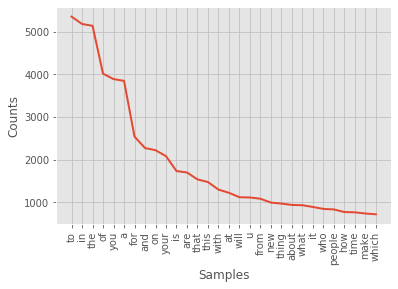

Current Vocab size is = 19545


In [231]:
def get_vocab_length(Series):
    corpus = " ".join(Series.to_list())
    corpus = tokenizer.tokenize(corpus)
    freqdist = FreqDist(corpus)
    freqdist.plot(30)
    print(f"Current Vocab size is = {len(freqdist)}")
    return freqdist

# def find_non_normal_chars(Series):
#     get

foo = get_vocab_length(X_train.text_lemmatised)

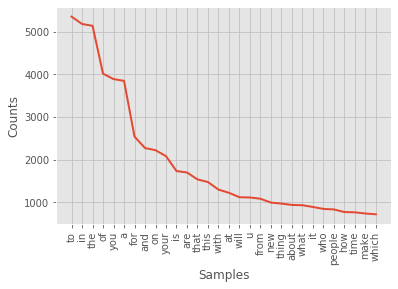

Current Vocab size is = 19545


In [232]:
test_series = X_train.text.apply(cleaner)
test_series_lemmed = test_series.apply(lemmetise)
bar = get_vocab_length(test_series_lemmed)

In [233]:
X_train_tfidf = tfidf_.fit_transform(X_train.text_lemmatised)
X_test_tfidf = tfidf_.transform(X_test.text_lemmatised)

In [234]:
y_test.shape, X_test_tfidf.shape

((6400, 1), (6400, 122424))

In [235]:
clf = BernoulliNB(alpha=0.3) # alpha 0.36 was choosen arbitralily
clf.fit(X_train_tfidf, y_train)
y_hat = clf.predict(X_test_tfidf)

accuracy_score(y_test, y_hat)

0.96328125

In [236]:
f1_score(y_test, y_hat)

0.9636616669243854

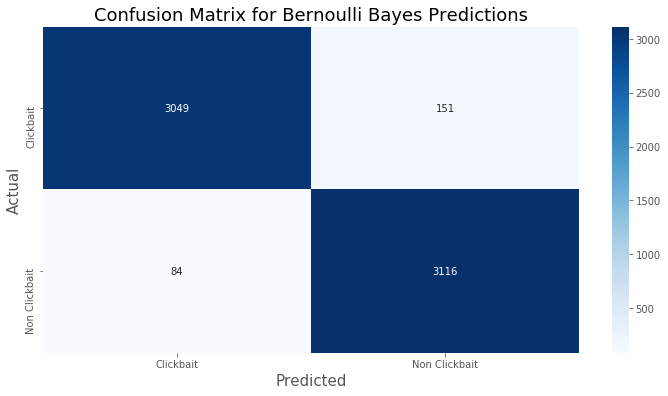

In [237]:

def plot_cmatrix(actual, predictions, model = None):
    '''Takes in arrays of actual binary values and model predictions and generates and plots a confusion matrix'''
    cmatrix = confusion_matrix(actual, predictions)

    fig, ax = plt.subplots(figsize = (12,6))
    sns.heatmap(cmatrix, annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.set_xticklabels(['Clickbait', 'Non Clickbait'])
    ax.set_yticklabels(['Clickbait', 'Non Clickbait'])
    ax.set_ylabel('Actual', size=15)
    ax.set_xlabel('Predicted', size=15)
    ax.set_title(f'Confusion Matrix for {model} Predictions', size =18)
    

plot_cmatrix(y_test, y_hat, model= "Bernoulli Bayes")

In [238]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0
)

In [239]:
rf_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [240]:
y_hat_rf = rf_classifier.predict(X_test_tfidf)

In [241]:
accuracy_score(y_test, y_hat_rf)


0.921875

In [242]:
X_train_tfidf.shape

(25600, 122424)

### Now that I have a baseline model/I need to apply the same methods to the other two data frames.

If they perform similarly, I can start thinking about takin the model into production.

Next steps:
- train test and holdout
- testing the current model on unseeen data fromn other data sets
- 

# Dataset 2.

Creation is outlined in `datasetCreation`. The goal here is to try and salvage as much of the 3000 tweets as possible. given that the data set is not balanced, I am also gonig to use this data as a natural "holdout" data set.

In [243]:
PATH2 = '../../src/data/dataframe2.csv'
df2 = pd.read_csv(PATH2)
df2.head()

,id,post_text,name,dataset,target
0,609398299926339584,RT @BuzzFeedBooks: John Green responded on Tum...,BuzzFeed,2,0
1,609858047670923265,ISIS intercepts thousands of Syrian refugees t...,Daily Mail Online,2,0
2,607934124813205505,RT @foxnewslatino: Carlos Santana (and his wif...,Fox News,2,0
3,609361820944605185,Female scientists fire back at Nobel laureate’...,Yahoo,2,0
4,610056503626698752,RT @davidshukmanbbc: Amazing news from deep sp...,BBC News (UK),2,0


In [244]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2992 entries, 0 to 2991
Data columns (total 5 columns):
id           2992 non-null int64
post_text    2992 non-null object
name         2992 non-null object
dataset      2992 non-null int64
target       2992 non-null int64
dtypes: int64(3), object(2)
memory usage: 117.0+ KB


In [245]:
df2.shape

(2992, 5)

Text(0, 0.5, 'Document Count')

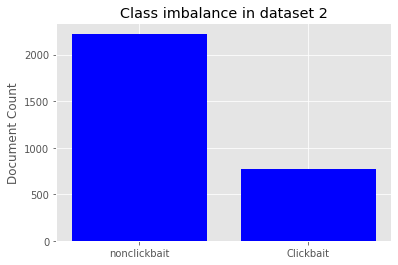

In [246]:
plt.bar(x=['nonclickbait', 'Clickbait'], height=df2.groupby(['target']).target.count(), color='b');
plt.title("Class imbalance in dataset 2")
plt.ylabel("Document Count")

In [247]:
df2.groupby(['target']).target.count()

target
0    2225
1     767
Name: target, dtype: int64

### So there is a 3:1 class imbalance. 

In addition, as these are tweets, they are pretty messy. "RT" and "@" are everywhere, I am going to have to clean them out. In addition, there are entire htmls.

Let's built a function that can clean the obvious stuff from the tweets and then generate some word clouds and look into what we see.

Note that the textblob spell checker is very slow. It should be used once over night and the series should be pickled. 

Note, that what works for news headlines doesn't necessarily work for tweets. I will first try and apply the news headline model to the tweets and get a baseline off of that

In [248]:
df2.head()

,id,post_text,name,dataset,target
0,609398299926339584,RT @BuzzFeedBooks: John Green responded on Tum...,BuzzFeed,2,0
1,609858047670923265,ISIS intercepts thousands of Syrian refugees t...,Daily Mail Online,2,0
2,607934124813205505,RT @foxnewslatino: Carlos Santana (and his wif...,Fox News,2,0
3,609361820944605185,Female scientists fire back at Nobel laureate’...,Yahoo,2,0
4,610056503626698752,RT @davidshukmanbbc: Amazing news from deep sp...,BBC News (UK),2,0


In [249]:
df2.post_text[1]

'ISIS intercepts thousands of Syrian refugees trying to escape http://t.co/1kL2ZW3Fbj http://t.co/goZAYSZ6wt'

## Removing http

In [279]:
def cleaner(tweet):
    text=re.compile("(http\w+)")
    tweet= tweet.replace("RT", "")
    tweet = "".join([char.lower() for char in tweet if char not in string.punctuation + "’" + "‘" + "“" + "–" + "”"])
    return " ".join(word for word in tweet.split() if word not in text.findall(tweet))

df2.post_text = df2.post_text.apply(cleaner)

In [280]:
"–" == "-"

False

In [281]:
df2.post_text[1]

'isis intercepts thousands of syrian refugees trying to escape'

### Examine the data set

In [282]:
# Get corpus
def get_corpus(df, text='text'):
    return " ".join(df[text].to_list())

click_corpus = get_corpus(df2[df2.target==1], text='post_text')
non_corpus = get_corpus(df2[df2.target==0], text='post_text')

len(click_corpus), len(non_corpus)

(52832, 176048)

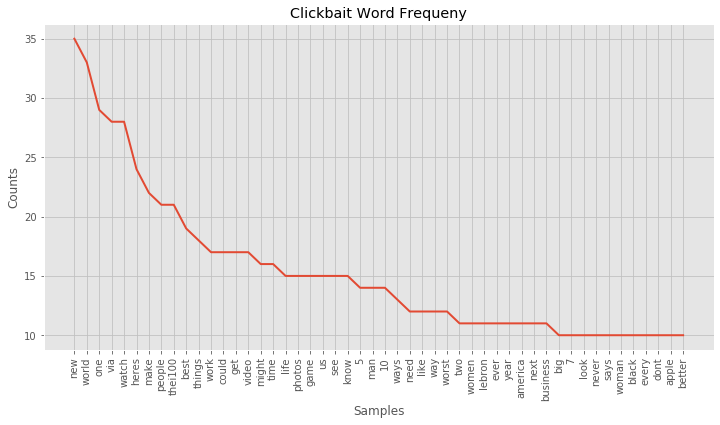

In [283]:
# Tokenizer 
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9!]+') # included ! in the analysis
click_tokenized = tokenizer.tokenize(click_corpus)
non_tokenized = tokenizer.tokenize(non_corpus)

fil_click = [word.lower() for word in click_tokenized if word.lower() not in stop_words]
fil_non = [word.lower() for word in non_tokenized if word.lower() not in stop_words]

# Freq Dict
click_dict = FreqDist(fil_click)
non_dict = FreqDist(fil_non)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

click_dict.plot(50, title="Clickbait Word Frequeny")

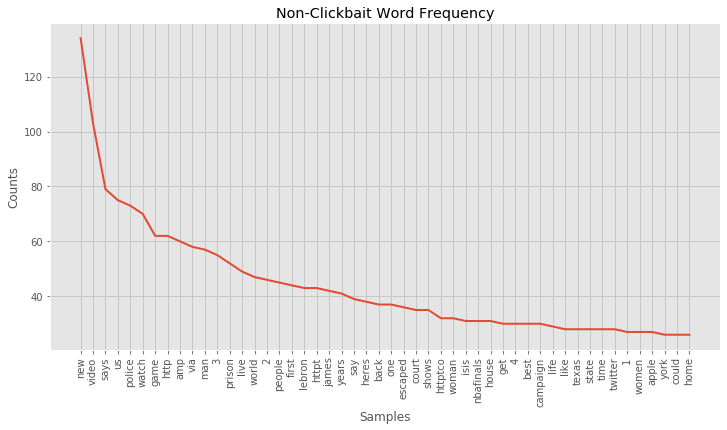

In [284]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

non_dict.plot(50, title="Non-Clickbait Word Frequency");

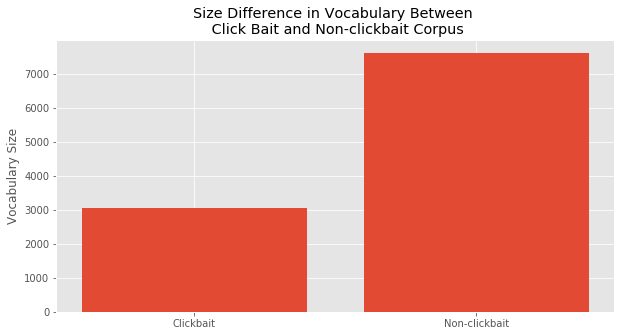

In [285]:
# Vocabulary check
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(x=["Clickbait", "Non-clickbait"], height=[len(click_dict), len(non_dict)])
ax.set_ylabel("Vocabulary Size")
plt.title("Size Difference in Vocabulary Between \n Click Bait and Non-clickbait Corpus");

The difference here is amplified by the class imbalance, without the class imbalance I suspect that the difference would not be nearly as stark. We can normalize the sizes of vocabulary by the size of each class.

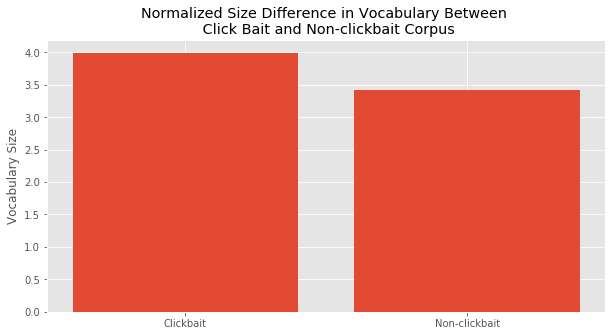

In [286]:
# Vocabulary check
fig, ax = plt.subplots(figsize=(10,5))
clicksize = df2[df2.target == 1].shape[0]
nonsize = df2[df2.target == 0].shape[0]
ax.bar(x=["Clickbait", "Non-clickbait"], height=[len(click_dict)/clicksize, len(non_dict)/nonsize])
ax.set_ylabel("Vocabulary Size")
plt.title("Normalized Size Difference in Vocabulary Between \n Click Bait and Non-clickbait Corpus");

The issue here is that after a certain point, all words are likely to be used. Therefore normalizing by the length if the length is really large actually offers up a disadvantage. I am not sure how best to represent this data.

But let's move on to the average size of the words. 

## Size of words used 

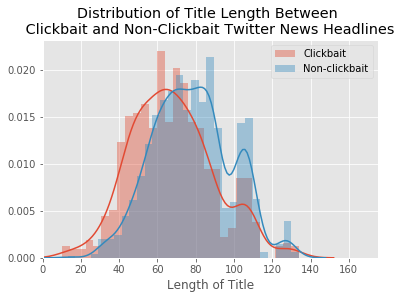

In [287]:
def get_len(string):
    return len(string)

click_len = df2[df2.target == 1].post_text.apply(get_len)
non_len = df2[df2.target == 0].post_text.apply(get_len)

fig, ax = plt.subplots()
for a, b in zip([click_len, non_len], ['Clickbait', 'Non-clickbait']):
    sns.distplot(a, bins=30, ax=ax, kde=True, label=b)
    plt.legend()
ax.set_xlim([0, 175])
ax.set_xlabel("Length of Title")
ax.set_title("Distribution of Title Length Between \n Clickbait and Non-Clickbait Twitter News Headlines ");

Ok, so it looks like there is a similar relationship to what we have seen previously. The sizes of the tweet posts are on overage a little bit longer. In addition, the clickbait here is actually shorter than the the headlines from the non-clickbait posts. This was not what I observed with the the previous data set. However, these are posts, not the actual headline.

In [288]:
words = set(nltk.corpus.words.words())

# Remove "RT" and "@"
def clean_tweets(tweet):
    tweet= tweet.replace("RT", "")
    tweet = "".join([char.lower() for char in tweet if char not in string.punctuation + "’"])
    return tweet.lstrip(" ").rstrip(" ")


def remove_non_english_words(tweet, words):
    return " ".join(word for word in nltk.wordpunct_tokenize(tweet) if word in words)

def spelling_correction(tweet):
    return " ".join([str(TextBlob(tweet).correct()) for word in tweet.split()])
    
def spelling_correction_v2(tweet):
    return " ".join([str(TextBlob(tweet).correct())])


# text_with_misspld_words = df2.post_text.apply(clean_tweets)

# text_without_misspld_words = text_with_misspld_words[0:10].apply(spelling_correction_v2)

In [289]:
# Assign the cleaned text to the data frame 


In [290]:
df2.shape

(2992, 5)

In [291]:
# try fiting the model to the text data
X_tweet = df2.post_text
y_tweet = df2.target

X_tweet_tfidf = tfidf_.transform(X_tweet)

y_hat_tweet = clf.predict(X_tweet_tfidf)
accuracy_score(y_tweet, y_hat_tweet)

0.6644385026737968

In [292]:
B_clf_tweet1 = BernoulliNB(alpha = 0.0001) # What is alpha?
tfidf_tweet_vec = TfidfVectorizer(stop_words = stop_words)

X_2_tfidf2 = tfidf_tweet_vec.fit_transform(X_tweet)

B_clf_tweet1.fit(X_2_tfidf2, y_tweet)

y_hat_3_2 = B_clf_tweet1.predict(X_2_tfidf2)

print(accuracy_score(y_tweet, y_hat_3_2))

confusion_matrix(y_tweet, y_hat_3_2)

0.9856283422459893


array([[2187,   38],
       [   5,  762]])

In [293]:
# Look at the false positive tweets:

fp2 = pd.Series(get_false_positives(y_tweet, y_hat_3_2), name='fp')
fn2 = pd.Series(get_false_negatives(y_tweet, y_hat_3_2), name='fn')

df2_withmisses = pd.concat([df2, fp2, fn2], axis=1)

(df2_withmisses[df2_withmisses.fn == 1].post_text)

# set([name.lower() for name in df2.name.to_list()])

61      24 couples who didnt let bad weather ruin thei...
73      the curious case of the cat with the overgrown...
190     have an old mac here are some tips on how to s...
251     klay thompson finds andre iguodala who throws ...
354     can you love a robot and one day can it love y...
457     bmws new 7 series is the luxury car of the fut...
584     this nontraditional wedding will hit you right...
627     how can you observe ramadan when the sun never...
632                      no intervention on pension firms
655     the remarkable ways europe is changing how peo...
728     missed apples wwdc 2015 keynote heres all the ...
800     someone put 1000 cardboard cuttouts of nicki m...
831     climate hope city how minecraft can tell the s...
953              why does the cabletv bundle exist anyway
1045    mitt romney republican presidential ticket cou...
1071    finally americans are starting to believe in t...
1138    sorry skeptics global warming may not be so gr...
1150    an ope

### NEWFLASH Tweets are not the same as News Headlines. 

I could go into the news articles themselves, I have access to the urls. I could set up a scraper that goes into each of the urls and pull out the headline and appends it to the dataframe. This way, I can look past the the post and analyse the url underneath it directly.

I am not suire that I want to include this data set into my final analysis as I will technically not be looking at 

# Load dataset3

This dataset is also from twitter data but unlike dataset2, the target title is actually included in the data frame making it readily available for analysis.

In [294]:
PATH3 = '../../src/data/dataframe3.csv'
df3 = pd.read_csv(PATH3)
df3.head()

,id,post_text,title,timestamp,dataset,target
0,858462320779026433,UK’s response to modern slavery leaving victim...,‘Inexcusable’ failures in UK’s response to mod...,Sat Apr 29 23:25:41 +0000 2017,3,0
1,858421020331560960,this is good,Donald Trump Appoints Pro-Life Advocate as Ass...,Sat Apr 29 20:41:34 +0000 2017,3,1
2,858368123753435136,"The ""forgotten"" Trump roast: Relive his brutal...",The ‘forgotten’ Trump roast: Relive his brutal...,Sat Apr 29 17:11:23 +0000 2017,3,0
3,858323428260139008,Meet the happiest #dog in the world!,"Meet The Happiest Dog In The World, Maru The H...",Sat Apr 29 14:13:46 +0000 2017,3,1
4,858283602626347008,Tokyo's subway is shut down amid fears over an...,Tokyo's subway is shut down amid fears over an...,Sat Apr 29 11:35:31 +0000 2017,3,0


In [295]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19538 entries, 0 to 19537
Data columns (total 6 columns):
id           19538 non-null int64
post_text    19484 non-null object
title        19538 non-null object
timestamp    19538 non-null object
dataset      19538 non-null int64
target       19538 non-null int64
dtypes: int64(3), object(3)
memory usage: 916.0+ KB


In [296]:
df3.shape

(19538, 6)

Text(0, 0.5, 'Document Count')

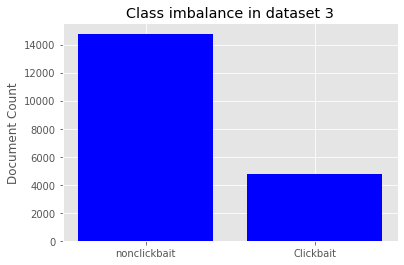

In [297]:
plt.bar(x=['nonclickbait', 'Clickbait'], height=df3.groupby(['target']).target.count(), color='b');
plt.title("Class imbalance in dataset 3")
plt.ylabel("Document Count")

### We have another case of class imbalance.

Let's take a closer look at the data and see if there are consistant metrics accross the data sets.

Understanding the data: These are headlines, not twitter posts. However, I could make two models, one for the 20k tweet posts and one for the 50k headlines that I have.

In [298]:
# Let's look at the distrubtion of word frequencies in the data

# Create corpus:
click3 = df3[df3.target == 1]
click3.title = click3.title.apply(cleaner)

non3 = df3[df3.target == 0]
non3.title = non3.title.apply(cleaner)


click3_corpus = " ".join([text for text in click3.title.to_list()])
non3_corpus = " ".join([text for text in non3.title.to_list()])

# tokenmize the data
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9!]+') 

click3_tokenized = tokenizer.tokenize(click3_corpus)
non3_tokenized = tokenizer.tokenize(non3_corpus)

fil_click3 = [word.lower() for word in click3_tokenized if word.lower() not in stop_words]
fil_non3 = [word.lower() for word in non3_tokenized if word.lower() not in stop_words]

# Create frequency dictionaries 
click3_dict = FreqDist(fil_click3)
non3_dict = FreqDist(fil_non3)

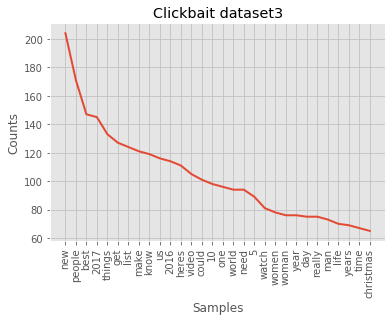

In [299]:
# Plot the Frequency Distribution of click bait

click3_dict.plot(30, title="Clickbait dataset3");

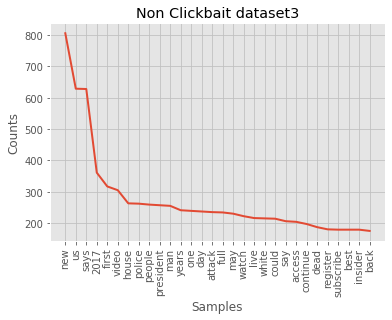

In [300]:
# plot the non-click bait Distribution 
non3_dict.plot(30, title="Non Clickbait dataset3");

In [301]:
X_3 = df3['title']
y_3 = df3['target']

X_3_tfidf = tfidf_.transform(X_3)

y_hat_3_1 = clf.predict(X_3_tfidf)

accuracy_score(y_3, y_hat_3_1)

0.6596376292353363

In [302]:
y_3.shape, y_hat_3_1.shape, X_3_tfidf.shape

((19538,), (19538,), (19538, 122424))

In [303]:
# What if we trained everything onto this data set?

In [304]:
B_clf_tweet = BernoulliNB(alpha=0)
tfidf_tweet_vec = TfidfVectorizer(stop_words = stop_words)

X_3_tfidf2 = tfidf_tweet_vec.fit_transform(X_3)

B_clf_tweet.fit(X_3_tfidf2, y_3)
y_hat_3_2 = B_clf_tweet.predict(X_3_tfidf2)

accuracy_score(y_3, y_hat_3_2)

0.9146279045961716

In [305]:
confusion_matrix(y_3, y_hat_3_2)

array([[13841,   936],
       [  732,  4029]])

# Ok so dataset three isn't performing nearly as well yet these are headlines from news agencies but does perform better if we make a new model for it.

Far more EDA is needed in order to understand the difference between these data sets. The reason for the drop in performance could be that the amazon mechanical turk method just isn't as accurate as as the method used in the chakboro paper. 

Either way more 


# Join 1 and 3 together and make a model from it

In [313]:
# Load dataframe 1
PATH = '../../src/data/dataframe1.csv'

df = pd.read_csv(PATH)
df.head()
df3_to_concat = df3[['title', 'dataset', 'target']]
df1 = pd.concat([df, pd.Series([1 for i in range(len(df))])], axis=1)

df1 = df1[['text', 0, 'target']]
df1.columns = ['title', 'dataset', 'target']

df_13 = pd.concat([df1, df3_to_concat], axis=0)
len(df)

32000

Text(0, 0.5, 'Document Count')

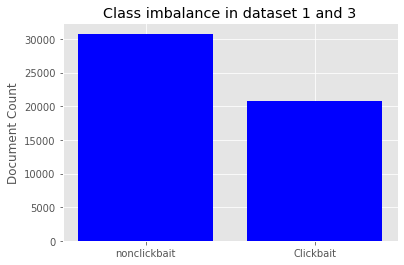

In [314]:
plt.bar(x=['nonclickbait', 'Clickbait'], height=df_13.groupby(['target']).target.count(), color='b');
plt.title("Class imbalance in dataset 1 and 3")
plt.ylabel("Document Count")

In [315]:
# The class imbalance my not be such a large issue, but I will first train test split, stratifying my data
X = df_13.title
y = df_13.target

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, 
                                                            test_size = 0.2, 
                                                            random_state = 42, 
                                                            stratify = df_13[['dataset', 'target']])
# Stratified the data so that both the target and data set were represented
X_train13.shape, X_test13.shape, y_train13.shape, y_test13.shape

((41230,), (10308,), (41230,), (10308,))

# First, let's run a vanilla model on the whole data set

In [309]:
# Instantiate a tfidfVectorizer
tfidf13 = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,5))

X_train13_tfidf = tfidf13.fit_transform(X_train13)
X_test13_tfidf = tfidf13.transform(X_test13)

print(X_train13_tfidf.shape)
# Instantiate a Bernouli Naive Bayes and run the model

bayes_clf = BernoulliNB(alpha = 0.3)
bayes_clf.fit(X_train13_tfidf, y_train13)
y_hat13 = bayes_clf.predict(X_test13_tfidf)

accuracy_score(y_test13, y_hat13)


(41230, 690543)


0.8822273961971284

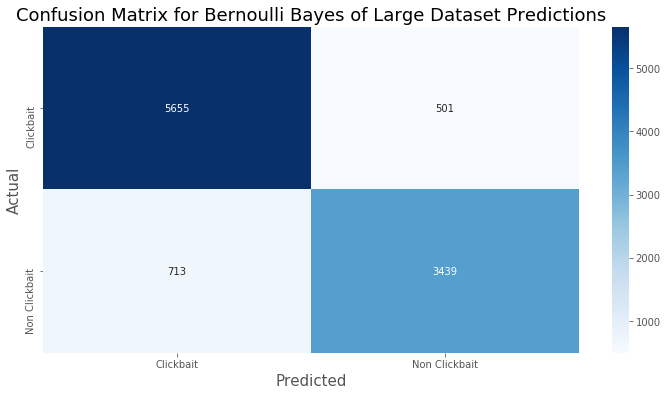

In [310]:
plot_cmatrix(y_test13, y_hat13, model= "Bernoulli Bayes of Large Dataset")

In [311]:
from sklearn.metrics import classification_report

print(classification_report(y_test13, y_hat13))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      6156
           1       0.87      0.83      0.85      4152

    accuracy                           0.88     10308
   macro avg       0.88      0.87      0.88     10308
weighted avg       0.88      0.88      0.88     10308



# Logistic Regression

In [ ]:
y_hat_lr = lr_CV.predict(X_test13_tfidf)

accuracy_score(y_test13, y_hat_lr)

# Currently, we are sitting at 0.88 accuracy on test


Great place to leave it. Feeling very good about going into the weekend.

Let's join all 3 together and see if we can get similar accuracy and f1 scores


In [312]:
bayes_clf = BernoulliNB(alpha = 0.3)
bayes_clf.fit(X_train13_tfidf, y_train13)
y_hat13 = bayes_clf.predict(X_train13_tfidf)

accuracy_score(y_train13, y_hat13)


0.995512975988358

In [114]:
df_13.head(3)

,title,dataset,target
0,Bill Changing Credit Card Rules Is Sent to Oba...,1,0
1,"In Hollywood, the Easy-Money Generation Toughe...",1,0
2,1700 runners still unaccounted for in UK's Lak...,1,0


In [340]:
df_13.shape

(51538, 3)

In [139]:
df2_to_concat = df2[['post_text', 'dataset', 'target']]
df2_to_concat.columns = ['title', 'dataset', 'target']

df123 = pd.concat([df_13, df2_to_concat])

df123['cleaned_title'] = df123.title.apply(cleaner)

In [271]:
# test train split
X123 = df123.cleaned_title
y123 = df123.target

X_train123, X_test123, y_train123, y_test123 = train_test_split(X123,
                                                                y123,
                                                                random_state = 42,
                                                                test_size = 0.2, stratify= df123.dataset)

X_train123.shape, X_test123.shape, y_train123.shape, y_test123.shape

((43624,), (10906,), (43624,), (10906,))

In [141]:
X_train123_tfidf.shape

(43624, 234563)

In [337]:
from sklearn.naive_bayes import GaussianNB
tfidf123 = TfidfVectorizer(stop_words = stop_words, ngram_range=(1,2))

X_train123_tfidf = tfidf123.fit_transform(X_train123)
X_test123_tfidf = tfidf123.transform(X_test123)

clf_b123 = BernoulliNB(alpha=0.1)

clf_b123.fit(X_train123_tfidf, y_train123)


y_hat123_train = clf_b123.predict(X_train123_tfidf)
y_hat123_test = clf_b123.predict(X_test123_tfidf)


acc_train = accuracy_score(y_train123, y_hat123_train)
acc_test = accuracy_score(y_test123, y_hat123_test)

In [338]:

acc_train, acc_test

(0.9918622776453329, 0.8706216761415735)

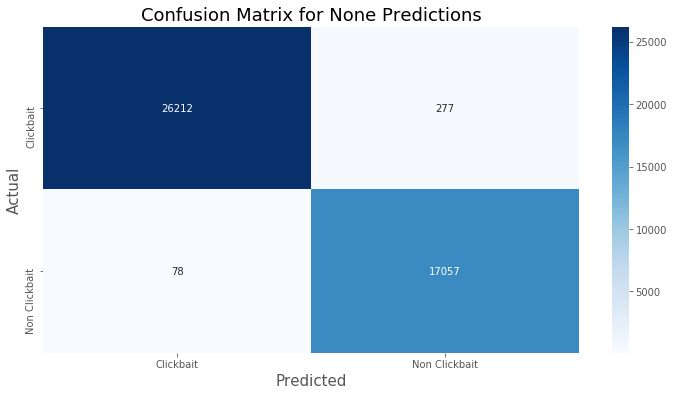

In [339]:
plot_cmatrix(y_train123, y_hat123_train)

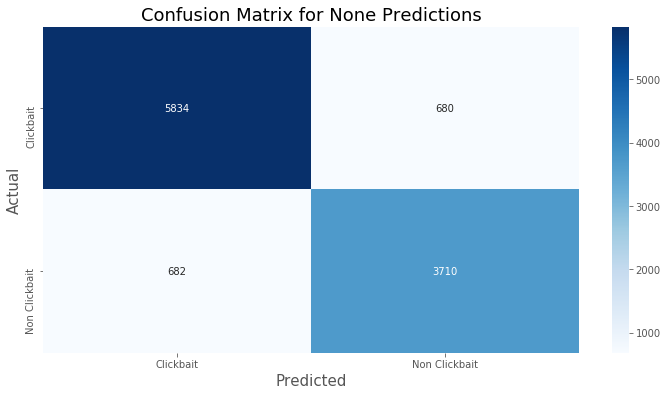

In [145]:
plot_cmatrix(y_test123, y_hat123_test)

In [328]:
np.mean(clf_b123.predict_proba(X_test123_tfidf)[:,1]) + np.mean(clf_b123.predict_proba(X_test123_tfidf)[:,0])

1.0

In [148]:
f1_score(y_test123, y_hat123_test)

0.8449100432703258

In [278]:
# Let's look at false negatives and false positives

fn123 = pd.Series(get_false_negatives(y_test123, y_hat123_test), name = 'fn')
fp123 = pd.Series(get_false_positives(y_test123, y_hat123_test), name = 'fp')


df123_fnfp = pd.concat([X_test123.reset_index(), fn123, fp123], axis=1)

for text in df123_fnfp[df123_fnfp.fn == 1].cleaned_title.to_list():
    print(text)

a busy night then a busier day at work
bernie sanders has a podcast now so you can feel the bern all year long
she believed in helping people remembering master sgt debra clayton
good morning angels explore what defined 70s tv tonight on the premiere of seventiescnn
how we built indias biggest robot company
aulii cravalho is the irl disney princess we all need right now
bachelor in paradise season 2 cast revealed
uber and lyft drivers share the 14 weirdest things theyve ever experienced on the job
students stand when called upon and when not
what kids wish their teachers knew
zambian shoppers run in terror when strange harry potter dementor figure appears in clouds
all the star wars movies ranked from worst to best
for everyone who knows the holiday” is better than love actually”
caitlyn jenner has an impressive new mac collection on the way
did you know mixing chocolate with caffeine can ease anxiety and help you focus better
nine things youre doing wrong in a cocktail bar
channing ta

In [147]:
df123.head(3)

,title,dataset,target,cleaned_title
0,Bill Changing Credit Card Rules Is Sent to Oba...,1,0,bill changing credit card rules is sent to oba...
1,"In Hollywood, the Easy-Money Generation Toughe...",1,0,in hollywood the easymoney generation toughens up
2,1700 runners still unaccounted for in UK's Lak...,1,0,1700 runners still unaccounted for in uks lake...


## Thoughts and conclusions

I don't think that we should include the second dataset in the final analysis. Twitter posts are fundamentally different to news headlines and should not be treated as the same. I do have access to the news urls that are in the tweet. I will use those urls as my test for the final model.

Therefore, I will go ahead with df1 plus df3. 

Final shape (51538, 3). 50k+ is completely respectable. I will save that and then export to the final notebook to modelling.

In [343]:
df_13.to_csv('../../src/data/df_one_plus_three.csv', index=False)